# Tutorial 6: BMMCs profiled with NTT-seq (H3K27ac + H3K27me3)

In this tutorial, we analyze bone marrow mononuclear cells (BMMCs) profiled using NTT-seq, as described in [Stuart et al., 2022](https://www.nature.com/articles/s41587-022-01588-5). The dataset includes two histone modifications:

- **H3K27me3** – Trimethylation of lysine 27 on histone H3,
- **H3K27ac** – Acetylation of lysine 27 on histone H3.

Before proceeding, import all necessary packages and download the data. Data for this tutorial is available on [figshare](https://doi.org/10.6084/m9.figshare.28303934.v1).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ocelli as oci
import anndata as ad
from scipy.sparse import csr_matrix

! wget --content-disposition https://figshare.com/ndownloader/articles/28303934/versions/1
! unzip -o 28303934.zip
! rm 28303934.zip

--2025-01-29 18:48:53--  https://figshare.com/ndownloader/articles/28303934/versions/1
52.17.87.113, 54.170.28.5, 2a05:d018:1f4:d000:2b52:700c:3d58:74bf, ...
connected. to figshare.com (figshare.com)|52.17.87.113|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 33061651 (32M) [application/zip]
Saving to: ‘28303934.zip’

28303934.zip        100%[===================>]  31.53M  18.8MB/s    in 1.7s    

2025-01-29 18:48:55 (18.8 MB/s) - ‘28303934.zip’ saved [33061651/33061651]

Archive:  28303934.zip
 extracting: bmmc_nttseq_h3k27ac.h5ad  
 extracting: bmmc_nttseq_h3k27me3.h5ad  


## Loading and processing data

Begin by loading the dataset corresponding to the H3K27ac histone modification. The dataset includes pretrained LDA topics, which will be useful for downstream analysis.

In [2]:
h3k27ac = oci.read.h5ad('bmmc_nttseq_h3k27ac.h5ad')
#oci.pp.lda(h3k27ac, n_components=20, max_iter=50, random_state=17, verbose=1, n_jobs=50)

h3k27ac

AnnData object with n_obs × n_vars = 5236 × 71253
    obs: 'celltype'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

Repeat for H3K27me3.

In [3]:
h3k27me3 = oci.read.h5ad('bmmc_nttseq_h3k27me3.h5ad')
#oci.pp.lda(h3k27me3, n_components=20, max_iter=50, random_state=17, verbose=1, n_jobs=50)

h3k27me3

AnnData object with n_obs × n_vars = 5236 × 43170
    obs: 'celltype'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

To train the Multimodal Diffusion Maps, we need to combine both histone modifications into a single `AnnData` object.

In [4]:
bmmc = ad.AnnData(csr_matrix(([],([],[])), shape=(5236, 1000)))

bmmc.obsm['h3k27ac'] = h3k27ac.obsm['X_lda']
bmmc.obsm['h3k27me3'] = h3k27me3.obsm['X_lda']
bmmc.uns['modalities'] = ['h3k27ac', 'h3k27me3']

bmmc.obs.index = h3k27ac.obs.index.tolist()
bmmc.obs['celltype'] = h3k27ac.obs.celltype.tolist()

bmmc

AnnData object with n_obs × n_vars = 5236 × 1000
    obs: 'celltype'
    uns: 'modalities'
    obsm: 'h3k27ac', 'h3k27me3'

## Multimodal Diffusion Maps

Next, we create a 10-dimensional MDM embedding following the same procedure as in previous tutorials. This includes:

1. Computing nearest neighbors, 
2. Generating modality weights, 
3. Computing the MDM latent space.

In [5]:
oci.pp.neighbors(bmmc, n_neighbors=100, n_jobs=50, verbose=True)
oci.tl.modality_weights(bmmc, random_state=17, n_jobs=50, verbose=True)
oci.tl.MDM(bmmc, n_components=10, random_state=17, n_jobs=50, verbose=True)

[h3k27ac]	100 nearest neighbors calculated.
[h3k27me3]	100 nearest neighbors calculated.


2025-01-29 18:48:59,471	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2025-01-29 18:49:05,362	INFO worker.py:1518 -- Started a local Ray instance.


[h3k27ac]	Unimodal Markov chain calculated.
[h3k27me3]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


To explore the structure of the MDM latent space, we generate a 2D ForceAtlas2 embedding based on the nearest neighbors graph.

In [6]:
oci.pp.neighbors(bmmc, x=['X_mdm'], n_neighbors=20, n_jobs=50, verbose=True)
oci.tl.neighbors_graph(bmmc, x='X_mdm', n_edges=20, verbose=True)

oci.tl.fa2(bmmc, n_components=2, random_state=737, n_iter=10000, linlogmode=True, n_jobs=50, 
           flags='--scalingRatio 10 --outboundAttractionDistribution true')

[X_mdm]	20 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 29, 2025 6:49:17 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 6:49:17 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 5,236 (5,236 added)
Jan 29, 2025 6:49:17 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 104,720 (72,203 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 67.772s


## Louvain clustering

The downloaded dataset includes cell annotations. Here, we demonstrate how to assign cell types using Louvain clustering. First, we compute Louvain clusters using the MDM latent space. Once clusters are identified, we assign cell types based on the expression of known marker genes. After annotation, the cell types can be visualized on the ForceAtlas2 embedding, providing insights into the organization of multimodal data.

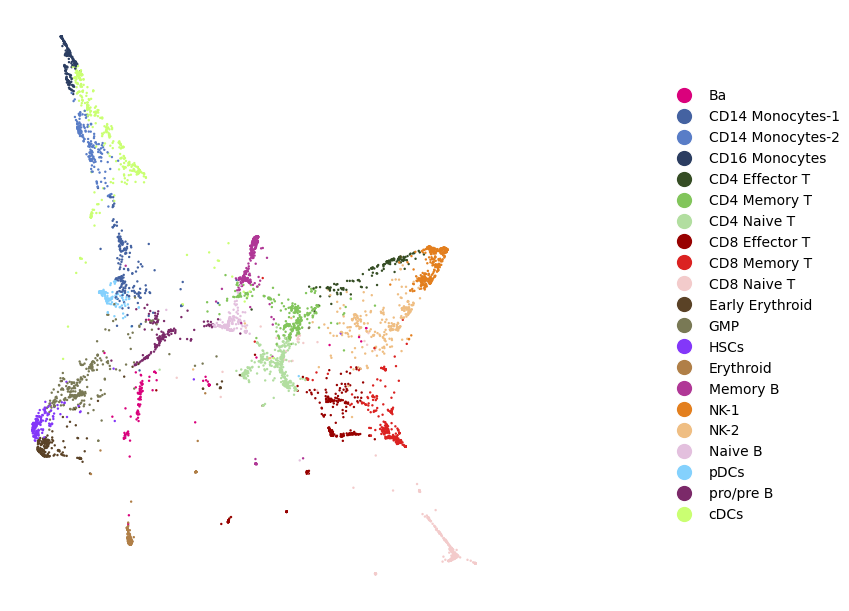

In [7]:
oci.tl.louvain(bmmc, x='X_mdm', random_state=17, n_neighbors=50, resolution=3)

mapping = {'0': 'CD4 Naive T',
           '1': 'NK-1',
           '2': 'cDCs',
           '3': 'Memory B',
           '4': 'CD8 Naive T',
           '5': 'CD4 Memory T',
           '6': 'CD8 Memory T',
           '7': 'NK-2',
           '8': 'GMP',
           '9': 'CD16 Monocytes',
           '10': 'CD8 Effector T',
           '11': 'Naive B',
           '12': 'Early Erythroid',
           '13': 'CD14 Monocytes-1',
           '14': 'CD14 Monocytes-2',
           '15': 'HSCs',
           '16': 'pro/pre B',
           '17': 'Erythroid',
           '18': 'pDCs',
           '19': 'CD4 Effector T',
           '20': 'Ba',
           '21': 'CD8 Effector T',
           '22': 'CD8 Effector T',
           '23': 'CD8 Memory T'}

bmmc.obs['celltype'] = [mapping[cluster] for cluster in bmmc.obs.louvain]

cdict = {'Ba': '#da017c',
         'CD14 Monocytes-1': '#4462a1',
         'CD14 Monocytes-2': '#597dc7',
         'CD16 Monocytes': '#2b3d61',
         'CD4 Effector T': '#354d24',
         'CD4 Memory T': '#82c55b',
         'CD4 Naive T': '#b2dea0',
         'CD8 Effector T': '#980100',
         'CD8 Memory T': '#db2221',
         'CD8 Naive T': '#f3cbcb',
         'Early Erythroid': '#5a4226',
         'GMP': '#797955',
         'HSCs': '#8337f9',
         'Erythroid': '#b07f47',
         'Memory B': '#b03796',
         'NK-1': '#e37f1e',
         'NK-2': '#efbe83',
         'Naive B': '#e3c0de',
         'pDCs': '#84d1fd',
         'pro/pre B': '#7b2969',
         'cDCs': '#caff72'}

oci.pl.scatter(bmmc, x='X_fa2', c='celltype', cdict=cdict, s=3, markerscale=2, 
               fontsize=10, figsize=(10, 6), title='')

## Exploring modality weights

In addition to clustering and annotation, you can explore the modality weight distributions for both histone modifications, H3K27ac and H3K27me3. By visualizing modality weights across cell types or clusters, you can assess whether certain cell populations rely more on one histone modification over the other, helping to interpret the biological relevance of the multimodal analysis.

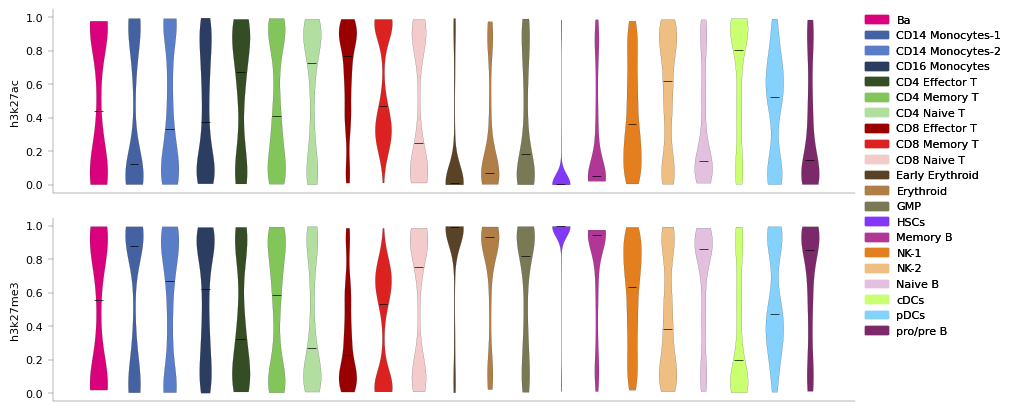

In [8]:
oci.pl.violin(bmmc, groups='celltype', values='weights', cdict=cdict, fontsize=8, 
              figsize=(10, 4))

This wraps up the tutorial, which provides a brief overview of how to analyze less commonly studied modalities such as histone modifications. By integrating and exploring multiple histone marks, we gain insights into chromatin state dynamics and their role in cellular heterogeneity. 

In Tutorial 7, you will learn how to use Ocelli when working with unimodal data.